In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import argparse


%matplotlib inline

In [3]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)

        img = cv2.imread(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))

        IMG.append(np.array(img))
    return IMG

In [4]:
#load data
early_blight_norm_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Normal',224))
#early_blight_serious_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Serious',224))
late_blight_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LateBlight',224))
healthy_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Healthy',224))
#insect_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Insect',224))
#lrv_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LeafRoll',224))
#virus_train =np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Virus',224))

early_blight_norm_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Normal',224))
#early_blight_serious_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Serious',224))
late_blight_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LateBlight',224))
healthy_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Healthy',224))
#insect_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Insect',224))
#lrv_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LeafRoll',224))
#virus_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Virus',224))

100%|██████████| 205/205 [00:02<00:00, 87.16it/s] 


In [5]:
# Create labels
early_blight_norm_train_label = np.full(len(early_blight_norm_train),0)
#early_blight_serious_train_label = np.full(len(early_blight_serious_train),1)
late_blight_train_label = np.full(len(late_blight_train),1)
healthy_train_label = np.full(len(healthy_train),2)
#insect_train_label = np.full(len(insect_train),4)
#lrv_train_label = np.full(len(lrv_train),5)
#virus_train_label = np.full(len(virus_train),6)

early_blight_norm_test_label = np.full(len(early_blight_norm_test),0)
#early_blight_serious_test_label = np.full(len(early_blight_serious_test),1)
late_blight_test_label = np.full(len(late_blight_test),1)
healthy_test_label = np.full(len(healthy_test),2)
#insect_test_label = np.full(len(insect_test),4)
#lrv_test_label = np.full(len(lrv_test),5)
#virus_test_label = np.full(len(virus_test),6)

In [6]:
# Merge data
X_train = np.concatenate((early_blight_norm_train, late_blight_train, healthy_train), axis = 0)
Y_train = np.concatenate((early_blight_norm_train_label, late_blight_train_label, healthy_train_label), axis = 0)
X_test = np.concatenate((early_blight_norm_test, late_blight_test, healthy_test), axis = 0)
Y_test = np.concatenate((early_blight_norm_test_label, late_blight_test_label, healthy_test_label), axis = 0)

In [7]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [8]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 3)
Y_test = to_categorical(Y_test, num_classes= 3)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [10]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images

    )

In [12]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

nasNetMobile     = NASNetMobile(include_top=False, input_shape=input_shape)(inputs)

19993432/19993432 [==============================] - 0s 0us/step


In [13]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(nasNetMobile)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(3, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 global_average_pooling2d (  (None, 1056)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 concatenate_4 (Concatenate  (None, 1056)              0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1056)              0         
                                                                 
 batch_normalization (Batch  (None, 1056)              4224  

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/NasNetMobile(3_classes).hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [15]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.6231 - accuracy: 0.6240

60/60 [==============================] - 78s 610ms/step - loss: 0.6231 - accuracy: 0.6240 - val_loss: 0.7332 - val_accuracy: 0.4083 - lr: 1.0000e-04
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.2938 - accuracy: 0.8917

60/60 [==============================] - 34s 567ms/step - loss: 0.2938 - accuracy: 0.8917 - val_loss: 0.6827 - val_accuracy: 0.3812 - lr: 1.0000e-04
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9250

60/60 [==============================] - 32s 532ms/step - loss: 0.1924 - accuracy: 0.9250 - val_loss: 0.6757 - val_accuracy: 0.4021 - lr: 1.0000e-04
Epoch 4/50
60/60 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.9229

60/60 [==============================] - 34s 562ms/step - loss: 0.1709 - accuracy: 0.9229 - val_loss: 0.6685 - val_accuracy: 0.3917 - lr: 1.0000e-04
Epoch 5/50
60/60 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.9427

60/60 [==============================] - 32s 540ms/step - loss: 0.1333 - accuracy: 0.9427 - val_loss: 0.6894 - val_accuracy: 0.3979 - lr: 1.0000e-04
Epoch 6/50
60/60 [==============================] - ETA: 0s - loss: 0.1169 - accuracy: 0.9500

60/60 [==============================] - 32s 530ms/step - loss: 0.1169 - accuracy: 0.9500 - val_loss: 0.7835 - val_accuracy: 0.3812 - lr: 1.0000e-04
Epoch 7/50
60/60 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9495

60/60 [==============================] - 32s 537ms/step - loss: 0.1136 - accuracy: 0.9495 - val_loss: 0.7704 - val_accuracy: 0.4062 - lr: 1.0000e-04
Epoch 8/50
60/60 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.9688

60/60 [==============================] - 32s 532ms/step - loss: 0.0790 - accuracy: 0.9688 - val_loss: 0.6877 - val_accuracy: 0.5104 - lr: 1.0000e-04
Epoch 9/50
60/60 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.9615

60/60 [==============================] - 32s 535ms/step - loss: 0.0983 - accuracy: 0.9615 - val_loss: 0.7725 - val_accuracy: 0.5042 - lr: 1.0000e-04
Epoch 10/50
60/60 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 0.9641

60/60 [==============================] - 32s 534ms/step - loss: 0.0758 - accuracy: 0.9641 - val_loss: 0.7195 - val_accuracy: 0.5771 - lr: 1.0000e-04
Epoch 11/50
60/60 [==============================] - ETA: 0s - loss: 0.0752 - accuracy: 0.9656

60/60 [==============================] - 32s 531ms/step - loss: 0.0752 - accuracy: 0.9656 - val_loss: 0.7541 - val_accuracy: 0.6187 - lr: 1.0000e-04
Epoch 12/50
60/60 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9745

60/60 [==============================] - 32s 536ms/step - loss: 0.0619 - accuracy: 0.9745 - val_loss: 0.5309 - val_accuracy: 0.6854 - lr: 1.0000e-04
Epoch 13/50
60/60 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9693

60/60 [==============================] - 33s 547ms/step - loss: 0.0767 - accuracy: 0.9693 - val_loss: 0.9740 - val_accuracy: 0.5708 - lr: 1.0000e-04
Epoch 14/50
60/60 [==============================] - ETA: 0s - loss: 0.0792 - accuracy: 0.9641

60/60 [==============================] - 32s 531ms/step - loss: 0.0792 - accuracy: 0.9641 - val_loss: 0.8205 - val_accuracy: 0.6313 - lr: 1.0000e-04
Epoch 15/50
60/60 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.9714

60/60 [==============================] - 33s 541ms/step - loss: 0.0663 - accuracy: 0.9714 - val_loss: 0.6638 - val_accuracy: 0.6771 - lr: 1.0000e-04
Epoch 16/50
60/60 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9734

60/60 [==============================] - 33s 556ms/step - loss: 0.0580 - accuracy: 0.9734 - val_loss: 0.7642 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 17/50
60/60 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9812

60/60 [==============================] - 34s 566ms/step - loss: 0.0496 - accuracy: 0.9812 - val_loss: 0.5744 - val_accuracy: 0.6917 - lr: 1.0000e-04
Epoch 18/50
60/60 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9734

60/60 [==============================] - 34s 555ms/step - loss: 0.0578 - accuracy: 0.9734 - val_loss: 0.5428 - val_accuracy: 0.7208 - lr: 1.0000e-04
Epoch 19/50
60/60 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9740

60/60 [==============================] - 32s 535ms/step - loss: 0.0534 - accuracy: 0.9740 - val_loss: 0.4602 - val_accuracy: 0.7604 - lr: 1.0000e-04
Epoch 20/50
60/60 [==============================] - ETA: 0s - loss: 0.0566 - accuracy: 0.9755

60/60 [==============================] - 33s 543ms/step - loss: 0.0566 - accuracy: 0.9755 - val_loss: 0.6210 - val_accuracy: 0.7229 - lr: 1.0000e-04
Epoch 21/50
60/60 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9802

60/60 [==============================] - 32s 532ms/step - loss: 0.0483 - accuracy: 0.9802 - val_loss: 0.5138 - val_accuracy: 0.7521 - lr: 1.0000e-04
Epoch 22/50
60/60 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9797

60/60 [==============================] - 32s 537ms/step - loss: 0.0458 - accuracy: 0.9797 - val_loss: 0.3906 - val_accuracy: 0.7958 - lr: 1.0000e-04
Epoch 23/50
60/60 [==============================] - ETA: 0s - loss: 0.0452 - accuracy: 0.9797

60/60 [==============================] - 32s 531ms/step - loss: 0.0452 - accuracy: 0.9797 - val_loss: 0.7516 - val_accuracy: 0.7083 - lr: 1.0000e-04
Epoch 24/50
60/60 [==============================] - ETA: 0s - loss: 0.0524 - accuracy: 0.9776

60/60 [==============================] - 32s 536ms/step - loss: 0.0524 - accuracy: 0.9776 - val_loss: 0.1752 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 25/50
60/60 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9745

60/60 [==============================] - 32s 526ms/step - loss: 0.0532 - accuracy: 0.9745 - val_loss: 0.3995 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 26/50
60/60 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9797

60/60 [==============================] - 32s 527ms/step - loss: 0.0487 - accuracy: 0.9797 - val_loss: 0.3495 - val_accuracy: 0.8188 - lr: 1.0000e-04
Epoch 27/50
60/60 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9797

60/60 [==============================] - 32s 541ms/step - loss: 0.0447 - accuracy: 0.9797 - val_loss: 0.2100 - val_accuracy: 0.8896 - lr: 1.0000e-04
Epoch 28/50
60/60 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9823

60/60 [==============================] - 32s 534ms/step - loss: 0.0441 - accuracy: 0.9823 - val_loss: 0.2650 - val_accuracy: 0.8646 - lr: 1.0000e-04
Epoch 29/50
60/60 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9807

60/60 [==============================] - 32s 538ms/step - loss: 0.0428 - accuracy: 0.9807 - val_loss: 0.2644 - val_accuracy: 0.8729 - lr: 1.0000e-04
Epoch 30/50
60/60 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.9792

60/60 [==============================] - 32s 532ms/step - loss: 0.0480 - accuracy: 0.9792 - val_loss: 0.2662 - val_accuracy: 0.8479 - lr: 1.0000e-04
Epoch 31/50
60/60 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.9797

60/60 [==============================] - 32s 536ms/step - loss: 0.0474 - accuracy: 0.9797 - val_loss: 0.1822 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 32/50
60/60 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.9823

60/60 [==============================] - 33s 538ms/step - loss: 0.0369 - accuracy: 0.9823 - val_loss: 0.0706 - val_accuracy: 0.9604 - lr: 1.0000e-04
Epoch 33/50
60/60 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9766

60/60 [==============================] - 32s 533ms/step - loss: 0.0422 - accuracy: 0.9766 - val_loss: 0.0631 - val_accuracy: 0.9750 - lr: 1.0000e-04
Epoch 34/50
60/60 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9750

60/60 [==============================] - 32s 529ms/step - loss: 0.0489 - accuracy: 0.9750 - val_loss: 0.0879 - val_accuracy: 0.9583 - lr: 1.0000e-04
Epoch 35/50
60/60 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9823

60/60 [==============================] - 32s 533ms/step - loss: 0.0441 - accuracy: 0.9823 - val_loss: 0.0593 - val_accuracy: 0.9812 - lr: 1.0000e-04
Epoch 36/50
60/60 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9833

60/60 [==============================] - 32s 532ms/step - loss: 0.0424 - accuracy: 0.9833 - val_loss: 0.0504 - val_accuracy: 0.9792 - lr: 1.0000e-04
Epoch 37/50
60/60 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.9885

60/60 [==============================] - 32s 530ms/step - loss: 0.0277 - accuracy: 0.9885 - val_loss: 0.0242 - val_accuracy: 0.9896 - lr: 1.0000e-04
Epoch 38/50
60/60 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9823

60/60 [==============================] - 33s 541ms/step - loss: 0.0397 - accuracy: 0.9823 - val_loss: 0.0438 - val_accuracy: 0.9833 - lr: 1.0000e-04
Epoch 39/50
60/60 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9823

60/60 [==============================] - 32s 539ms/step - loss: 0.0437 - accuracy: 0.9823 - val_loss: 0.0378 - val_accuracy: 0.9875 - lr: 1.0000e-04
Epoch 40/50
60/60 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9812

60/60 [==============================] - 32s 534ms/step - loss: 0.0397 - accuracy: 0.9812 - val_loss: 0.0265 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 41/50
60/60 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9885

60/60 [==============================] - 32s 531ms/step - loss: 0.0317 - accuracy: 0.9885 - val_loss: 0.0511 - val_accuracy: 0.9750 - lr: 1.0000e-04
Epoch 42/50
60/60 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9807

60/60 [==============================] - 32s 532ms/step - loss: 0.0429 - accuracy: 0.9807 - val_loss: 0.0864 - val_accuracy: 0.9604 - lr: 1.0000e-04
Epoch 43/50
60/60 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 0.9880

60/60 [==============================] - 32s 536ms/step - loss: 0.0262 - accuracy: 0.9880 - val_loss: 0.0436 - val_accuracy: 0.9792 - lr: 1.0000e-04
Epoch 44/50
60/60 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9880

60/60 [==============================] - 32s 535ms/step - loss: 0.0358 - accuracy: 0.9880 - val_loss: 0.0482 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 45/50
60/60 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9870

60/60 [==============================] - 33s 541ms/step - loss: 0.0263 - accuracy: 0.9870 - val_loss: 0.0437 - val_accuracy: 0.9812 - lr: 1.0000e-04
Epoch 46/50
60/60 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9833

60/60 [==============================] - 32s 526ms/step - loss: 0.0333 - accuracy: 0.9833 - val_loss: 0.0603 - val_accuracy: 0.9729 - lr: 1.0000e-04
Epoch 47/50
60/60 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 0.9812

60/60 [==============================] - 33s 537ms/step - loss: 0.0406 - accuracy: 0.9812 - val_loss: 0.0221 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 48/50
60/60 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9833

60/60 [==============================] - 33s 545ms/step - loss: 0.0296 - accuracy: 0.9833 - val_loss: 0.0770 - val_accuracy: 0.9688 - lr: 1.0000e-04
Epoch 49/50
60/60 [==============================] - ETA: 0s - loss: 0.0321 - accuracy: 0.9875

60/60 [==============================] - 32s 534ms/step - loss: 0.0321 - accuracy: 0.9875 - val_loss: 0.1344 - val_accuracy: 0.9292 - lr: 1.0000e-04
Epoch 50/50
60/60 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9859

60/60 [==============================] - 32s 534ms/step - loss: 0.0284 - accuracy: 0.9859 - val_loss: 0.0306 - val_accuracy: 0.9896 - lr: 1.0000e-04


20/20 [==============================] - 6s 91ms/step
Confusion matrix, without normalization
[[205   0   1]
 [  2 198   0]
 [  9   0 196]]


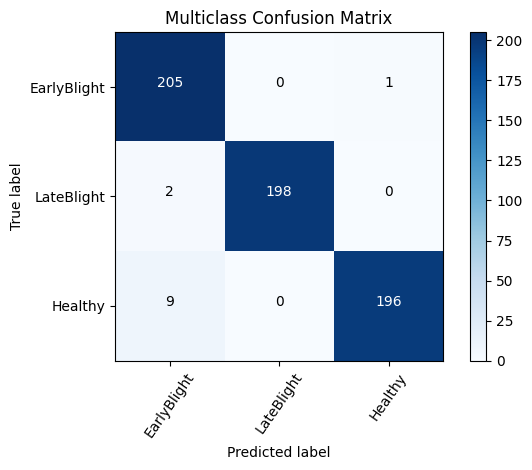

In [16]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['EarlyBlight', 'LateBlight','Healthy']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

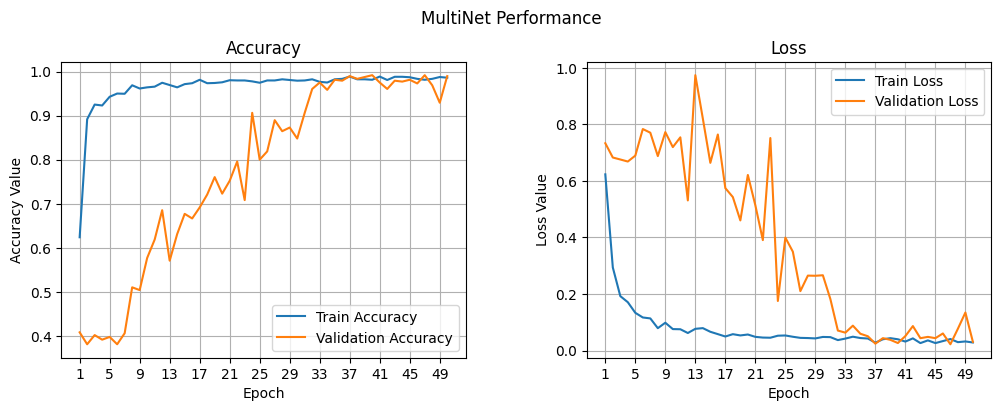

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MultiNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 51, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 51, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [18]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['EarlyBlight', 'LateBlight', 'Healthy']
print(classification_report(y_test, Y_pred, target_names=target_names))

20/20 [==============================] - 1s 65ms/step
Classification Report
              precision    recall  f1-score   support

 EarlyBlight       0.95      1.00      0.97       206
  LateBlight       1.00      0.99      0.99       200
     Healthy       0.99      0.96      0.98       205

    accuracy                           0.98       611
   macro avg       0.98      0.98      0.98       611
weighted avg       0.98      0.98      0.98       611



In [19]:
pred=model.predict(X_test)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)

Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

accuray = accuracy_score(Y_pred, y_test)
f1 = f1_score(Y_pred, y_test, average="weighted")
precision = precision_score(Y_pred, y_test, average='weighted')
recall = recall_score(Y_pred, y_test, average='weighted')
mse = mean_squared_error(Y_pred, y_test)
mae = mean_absolute_error(Y_pred, y_test)

print("NasNetMobile")
print("Accuracy:", accuray)
print("F1 Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("MSE:", mse)
print("MAE:", mae)

20/20 [==============================] - 1s 62ms/step
NasNetMobile
Accuracy: 0.9803600654664485
F1 Score: 0.9802984411103168
precision: 0.9808881764695168
recall: 0.9803600654664485
MSE: 0.06873977086743044
MAE: 0.03600654664484452


In [20]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
Y_test=np.argmax(Y_test,1)

20/20 [==============================] - 1s 60ms/step


In [21]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=2)
auc=metrics.auc(fpr, tpr)
auc

0.9661119788537786

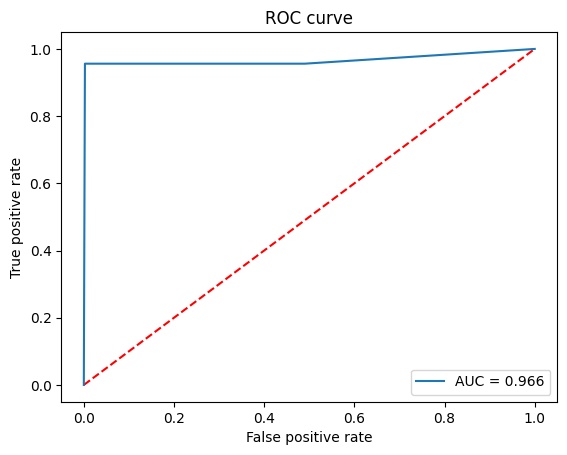

In [22]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()
